In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

## Modeling

In [24]:
features = [
  'asst_tot_quantile_values',
 'financial_leverage_quantile_values',
 'profitability_ratio_quantile_values',
 'net_income_growth_quantile_values',
 'quick_ratio_v2_quantile_values',
 'sales_growth_quantile_values',
 'cash_assets_ratio_quantile_values',
 'dscr_quantile_values',
    # 'ebitda',
    # 'is_first_occurrence'
]


## Walk forward

In [3]:
def predictor(new_df, model):
    predictions = model.predict(new_df)
    return(predictions)

In [4]:
# def preprocessor(df, preproc_params = {}, new = True):

#     quantiles = preproc_params['quantiles']
    
#     to_quantile_features = ['asst_tot',
#                  'financial_leverage',
#                  'profitability_ratio',
#                  'profit',
#                  # 'net_income_growth',
#                  'quick_ratio_v2',
#                  # 'sales_growth',
#                  'cash_assets_ratio',
#                  'dscr']

#     feature_names = []
    
#     for feature in to_quantile_features:
#         if new:
#             cut, bins = pd.qcut(df[feature], q=quantiles, retbins=True,labels=False, duplicates='drop')
            
#             prob_values = df.groupby(cut)[['default']].mean()

#             feature_name = f'{feature}_quantile_value'
#             feature_names.append(feature_name)
            
#             df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']
#             preproc_params['quantile_bins'][feature] = bins
            
#         else:
#             if feature not in preproc_params['quantile_bins']:
#                 raise Exception("Error bins haven't been fitted")
#             bins = preproc_params['quantile_bins'][feature]
            
#             cut = pd.cut(df[feature], bins=bins, labels=False, include_lowest=True)
#             prob_values = df.groupby(cut)[['default']].mean()

#             feature_name = f'{feature}_quantile_value'
#             feature_names.append(feature_name)
            
#             df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']

#     preproc_params['features'] = feature_names
    
#     return(df, preproc_params)

In [5]:
def estimator(df, fitting_algo, est_params = {}):
    
    my_formula = est_params['formula']
    model = fitting_algo(my_formula, data = df) 
    fitted_model = model.fit(disp=False)
    
    return(fitted_model)

In [6]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [27]:
def walk_forward_harness(df, preprocessor, estimator, predictor, 
                         start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    with open('quantile_custom_bins.pkl', 'rb') as file:
        custom_bins = pickle.load(file)
    
    preproc_params = {
        'quantile_bins' : {},
        'quantile_values' : {}
    }
    
    df[date_col] = pd.to_datetime(df[date_col])
    walk_range = df[date_col].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        print(stats_list)
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]
        print('Training range:',train_idx)
        print('Test step:',test_idx)

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        print(train_data.shape)
        print(test_data.shape)

        train_data_proc , preproc_params = pre_process(train_data, 
                                                       custom_bins=custom_bins, 
                                                       preproc_params = preproc_params,  
                                                       quantiles = 50, 
                                                       days_until_statement = 150)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        test_data_proc , preproc_params = pre_process(test_data, 
                                                     historical_df=train_data_proc, 
                                                     new=False, 
                                                     preproc_params = preproc_params,  
                                                     quantiles = 50, 
                                                     days_until_statement = 150)
        print(train_data_proc['default'].mean())
        print(test_data_proc['default'].mean())

        print(train_data_proc[features].tail(3))
        print(test_data_proc[features].tail(3))
        
        # formula = 'default ~ '+' + '.join(features)

        # model = smf.logit(formula, data = train_data_proc) 
        # logit_model_sm = model.fit()
        # print(logit_model_sm.summary())
        
        # predz = test_data_proc[['default']].copy()
        # predz['predicted_probability'] = logit_model_sm.predict(test_data_proc)
        # # predictions.dropna(inplace=True)
        # # predictions.head()
        # print(metrics.roc_auc_score(y_score=predz['predicted_probability'], y_true=predz['default']))
        
        algo_params = {'formula': 'default ~ '+' + '.join(features)}
        
        algo = smf.logit
    
        trained_model = estimator(train_data_proc, algo, algo_params)
        prediction = predictor(test_data_proc, trained_model)
        
        labels += list(test_data_proc['default'].values)
        predictions += list(prediction.values)
        
        
        group_list += test_idx * len(prediction)
        
        try:
            preds = pd.DataFrame([labels,predictions,group_list]).T
            preds.columns = ['label','prediction','group']
            # preds = preds.dropna()
            score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
            
        except Exception as e:
            print(F'Error scoring {e}')
            score = np.nan

        
        stats_list.append(score)
        model_list.append(trained_model)
        

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [28]:
df = pd.read_csv('../data/train.csv')
df.shape

(1023552, 44)

In [29]:
df['is_first_occurrence'] = (df['id'] != df['id'].shift()).astype(int)

In [30]:
modeling_df = df[df['is_first_occurrence']==0].copy()
print(modeling_df.shape)
len(modeling_df)/len(df)

(785841, 45)


0.767758746013881

In [31]:
modeling_df['stmt_date'] = pd.to_datetime(modeling_df['stmt_date'])
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [32]:
### we'll try dropping NA's for now
# modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()
modeling_df.sort_values('stmt_date', inplace=True)

In [33]:
features_needed = ['id',
                     'stmt_date',
                     # 'HQ_city',
                     # 'legal_struct',
                     # 'ateco_sector',
                     'def_date',
                     # 'fs_year',
                     # 'asst_intang_fixed',
                     # 'asst_tang_fixed',
                     # 'asst_fixed_fin',
                     # 'asst_current',
                     'AR',
                     'cash_and_equiv',
                     'asst_tot',
                     # 'eqty_tot',
                     # 'eqty_corp_family_tot',
                     # 'liab_lt',
                     # 'liab_lt_emp',
                     # 'debt_bank_st',
                     # 'debt_bank_lt',
                     # 'debt_fin_st',
                     # 'debt_fin_lt',
                     # 'AP_st',
                     # 'AP_lt',
                     'debt_st',
                     'debt_lt',
                     'rev_operating',
                     # 'COGS',
                     'prof_operations',
                     # 'goodwill',
                     # 'inc_financing',
                     'exp_financing',
                     # 'prof_financing',
                     # 'inc_extraord',
                     # 'taxes',
                     'profit',
                     # 'days_rec',
                     'ebitda',
                     # 'roa',
                     # 'roe',
                     # 'wc_net',
                     # 'margin_fin',
                     # 'cf_operations'
                  ]

In [34]:
modeling_df = modeling_df[features_needed]

In [35]:
modeling_df['def_date'] = pd.to_datetime(modeling_df['def_date'], format="%d/%m/%Y")

In [36]:
from harness_functions import pre_process

In [37]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           preprocessor = pre_process, 
                                                           estimator = estimator, 
                                                           predictor = predictor, 
                                                           date_col = 'stmt_date',
                                                           start = 1, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 6 Steps.'

In [44]:
predictions.isna().sum()

label         0
prediction    0
group         0
dtype: int64

In [39]:
# predictions = predictions.dropna()

ROC AUC 0.7531386038250116


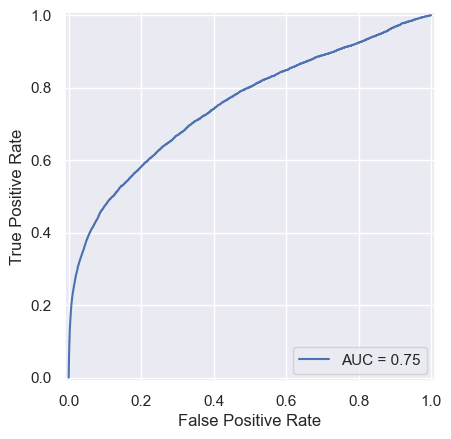

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

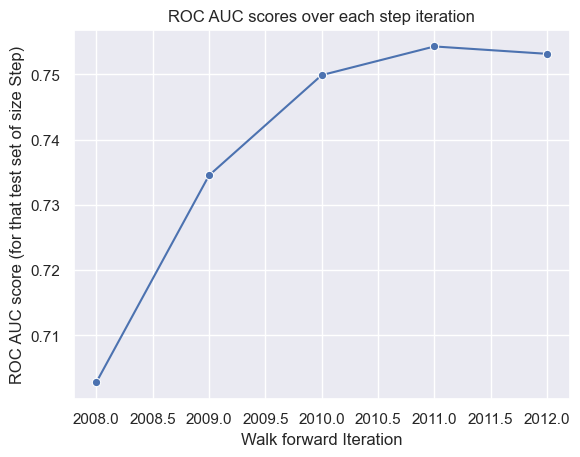

In [46]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [47]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

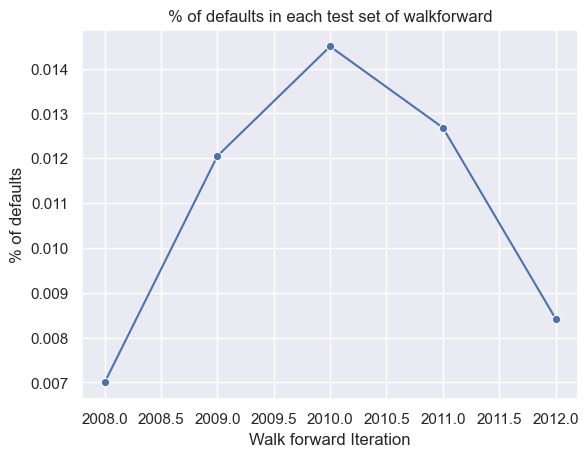

In [48]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')